In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import ot
import cvxpy as cp
import seaborn as sns
import twp_utils as twp

# Supplementary Packages
#import scipy.stats as stats
#import scipy.special as sps
#import time as t

## Medicare Data

In [2]:
def read_medicaid(file_name, columns, sample = True):
    
    df = pd.read_csv(file_name)[columns]
    
    if sample:
        df = df.sample(1500, random_state = 31)
    
    return(np.array(df))

In [3]:
import os, glob
medidata = []

columns1 = ['HINSCAID','EMPSTAT','UHRSWORK','INCWAGE']
for file in sorted(glob.glob("workingData/medicaid/*.csv")):
    medidata.append(read_medicaid(file, columns1))

medidata.insert(0, medidata.pop(5)) # Move Montana to front of list
medi_target = medidata[0]
medi_controls = medidata[1:]


#for counterfactual exercise
mt_years = read_medicaid("workingData/medicaid/MT.csv", ['YEAR'])

### Test Run

In [4]:
medi_weights, medi_projection = twp.tan_wass_proj(medi_target, medi_controls)

# round integer columns
medi_projection[:,0:2] = medi_projection[:,0:2].round(decimals = 0).astype('int32')

In [5]:
medi_target[0:5,:]

array([[ 1.        ,  1.        ,  2.72129543,  8.20193435],
       [ 1.        ,  1.        ,  4.98086314, 13.38312636],
       [ 1.        ,  1.        ,  4.61313836, 11.5696838 ],
       [ 1.        ,  1.        ,  3.60549785, 10.12021054],
       [ 1.        ,  1.        ,  3.85439389, 10.87993221]])

In [6]:
medi_projection[0:5,:]

array([[ 1.       ,  1.       ,  2.7301803,  8.302936 ],
       [ 1.       ,  1.       ,  4.7296977, 13.066231 ],
       [ 1.       ,  1.       ,  4.606846 , 11.638502 ],
       [ 1.       ,  1.       ,  3.6360972, 10.214581 ],
       [ 1.       ,  1.       ,  3.9365299, 10.964109 ]], dtype=float32)

In [7]:
medi_weights

array([ 1.83542468e-01, -7.41751449e-17, -7.62265727e-16, -2.64926653e-16,
        1.74431644e-01, -6.45043538e-16,  9.87702002e-03,  5.13099887e-01,
       -1.39495870e-17,  7.41989330e-17,  1.19048981e-01, -3.96550954e-16])

## RESULTS

### HINSCAID

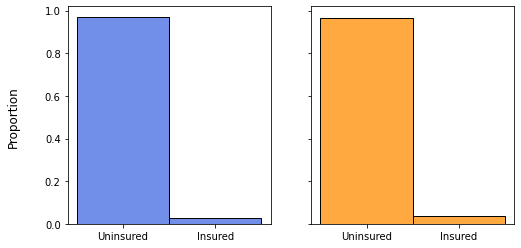

In [8]:
fig5, axes5 = plt.subplots(1,2, figsize = (8,4), sharex = True, sharey = True)

dict_map = {1:'Uninsured' , 2: 'Insured'}
reptemp = pd.DataFrame(medi_projection[:,0])
reptemp[0] = reptemp[0].map(dict_map)

targtemp = pd.DataFrame(medi_target[:,0])
targtemp[0] = targtemp[0].map(dict_map)

sns.histplot(reptemp, x = 0, ax = axes5[0], discrete = True, stat = 'density', color = 'royalblue')
sns.histplot(targtemp, x = 0, ax = axes5[1], discrete = True, stat = 'density', color = 'darkorange')
axes5[0].set(xlabel = None, ylabel = None)
axes5[1].set(xlabel = None, ylabel = None)
fig5.supylabel('Proportion')

plt.savefig('hinscaid_pre.png')

In [9]:
1500 - sum(medi_target[:,0] == medi_projection[:,0]) ## number of misses

16

### EMPSTAT

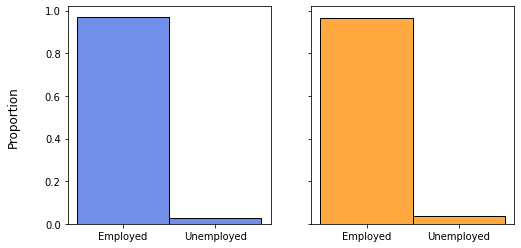

In [10]:
fig6, axes6 = plt.subplots(1,2, figsize = (8,4), sharex = True, sharey = True)

dict_map = {1:'Employed' , 2: 'Unemployed'}
reptemp = pd.DataFrame(medi_projection[:,0])
reptemp[0] = reptemp[0].map(dict_map)

targtemp = pd.DataFrame(medi_target[:,0])
targtemp[0] = targtemp[0].map(dict_map)

sns.histplot(reptemp, x = 0, ax = axes6[0], discrete = True, stat = 'density', color = 'royalblue')
sns.histplot(targtemp, x = 0, ax = axes6[1], discrete = True, stat = 'density', color = 'darkorange')
axes6[0].set(xlabel = None, ylabel = None)
axes6[1].set(xlabel = None, ylabel = None)
fig6.supylabel('Proportion')

plt.savefig('empstat_pre.png')

In [11]:
1500 - sum(medi_target[:,1] == medi_projection[:,1]) ## number of misses

15

### UHRSWORK

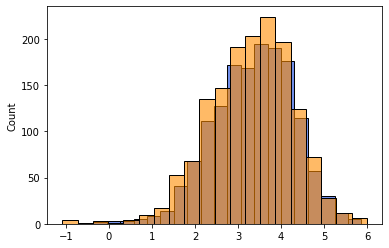

In [12]:
fig7, axes7 = plt.subplots()
sns.histplot(medi_projection[:,2], ax = axes7, bins = 20, color = 'royalblue')
sns.histplot(medi_target[:,2], ax = axes7, bins = 20, color = 'darkorange', alpha = 0.6)

plt.savefig('uhrswrk_pre.png')

### INCWAGE

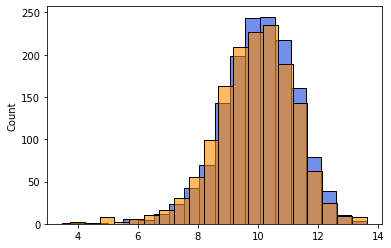

In [13]:
fig8, axes8 = plt.subplots()
sns.histplot(medi_projection[:,3], ax = axes8, bins = 20, color = 'royalblue')
sns.histplot(medi_target[:,3], ax = axes8, bins = 20, color = 'darkorange', alpha = 0.6)

plt.savefig('incwage_pre.png')

## Counterfactual Data

In [14]:
def read_medicaid2(file_name, columns, sample = True):
    
    df = pd.read_csv(file_name)[columns]
    
    if sample:
        df = df.sample(7775, random_state = 31) #7775 is minimum data size
    
    return(np.array(df)) 

In [15]:
postintv = []
import glob

# check path
for file in sorted(glob.glob("workingData/medicaid/Counterfactual/*.csv")):
    postintv.append(read_medicaid2(file, columns1))

postintv.insert(0, postintv.pop(5))
post_target = postintv[0]
post_controls = postintv[1:]

mt_years = read_medicaid2("workingData/medicaid/Counterfactual/MT_post.csv", ['YEAR'])

In [16]:
post_projection = sum([a*b for a,b in zip(medi_weights, post_controls)])
post_projection[:,0:2] = post_projection[:,0:2].round(decimals = 0).astype('int32')

### HINSCAID

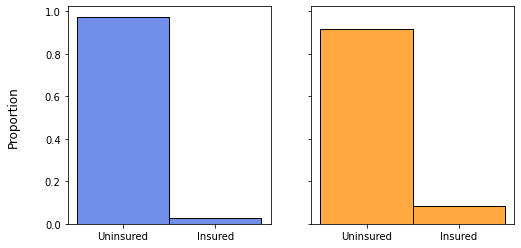

In [17]:
fig, axes = plt.subplots(1,2, figsize = (8,4), sharex = True, sharey = True)

dict_map = {1:'Uninsured' , 2: 'Insured'}
reptemp = pd.DataFrame(post_projection[:,0])
reptemp[0] = reptemp[0].map(dict_map)

targtemp = pd.DataFrame(post_target[:,0])
targtemp[0] = targtemp[0].map(dict_map)

sns.histplot(reptemp, x = 0, ax = axes[0], discrete = True, stat = 'density', color = 'royalblue')
sns.histplot(targtemp, x = 0, ax = axes[1], discrete = True, stat = 'density', color = 'darkorange')
axes[0].set(xlabel = None, ylabel = None)
axes[1].set(xlabel = None, ylabel = None)

fig.supylabel('Proportion')
plt.savefig('hinscaid_sep.png')

### EMPSTAT

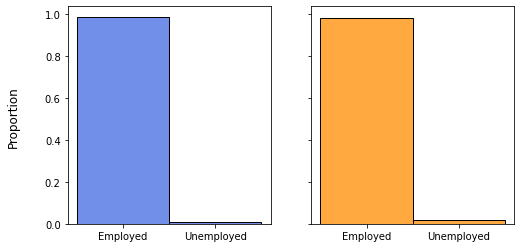

In [18]:
fig2, axes2 = plt.subplots(1,2, figsize = (8,4), sharex = True, sharey = True)

dict_map = {1:'Employed' , 2: 'Unemployed'}
reptemp = pd.DataFrame(post_projection[:,1])
reptemp[0] = reptemp[0].map(dict_map)

targtemp = pd.DataFrame(post_target[:,1])
targtemp[0] = targtemp[0].map(dict_map)

sns.histplot(reptemp, x = 0, ax = axes2[0], discrete = True, stat = 'density', color = 'royalblue')
sns.histplot(targtemp, x = 0, ax = axes2[1], discrete = True, stat = 'density', color = 'darkorange')
axes2[0].set(xlabel = None, ylabel = None)
axes2[1].set(xlabel = None, ylabel = None)

fig2.supylabel('Proportion')

plt.savefig('empstat_sep.png')

### UHRSWORK

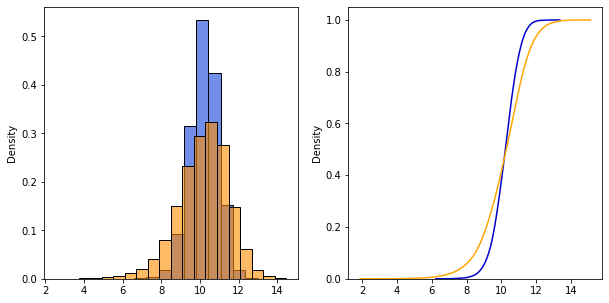

In [19]:
fig3, axes3 = plt.subplots(1,2, figsize = (10,5))
sns.histplot(post_projection[:,3], bins = 10, ax = axes3[0], color = 'royalblue', stat = 'density')
sns.kdeplot(post_projection[:,3], cumulative = True, ax = axes3[1], color = 'mediumblue')


sns.histplot(post_target[:,3], bins = 20, ax = axes3[0], color = 'darkorange', stat = 'density', alpha = 0.6)
sns.kdeplot(post_target[:,3], cumulative = True, ax = axes3[1], color = 'orange')

plt.savefig('incwage_superimposed.png')

### INCWAGE

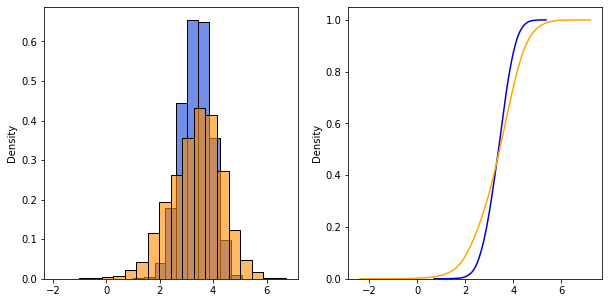

In [20]:
fig4, axes4 = plt.subplots(1,2, figsize = (10,5))
sns.histplot(post_projection[:,2], bins = 10, ax = axes4[0], color = 'royalblue', stat = 'density')
sns.kdeplot(post_projection[:,2], cumulative = True, ax = axes4[1], color = 'mediumblue')


sns.histplot(post_target[:,2], bins = 20, ax = axes4[0], color = 'darkorange', stat = 'density', alpha = 0.6)
sns.kdeplot(post_target[:,2], cumulative = True, ax = axes4[1], color = 'orange')

plt.savefig('uhrswork_superimposed.png')